Minimal example for masking tests.

In [2]:
import numpy as np
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import estimator as est
rng = np.random.default_rng(seed=315)
from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from lace.cosmo import camb_cosmo
from forestflow import pcross
from scipy.interpolate import interp1d
import mask_calculations as mc


In [3]:
# set simulation details
sim_name='sim_pair_30' # other version will be 'diffSeed'
sim_dir='central'
snap_num = 6
phase = "sim_minus"
axis = 1
# load the saved skewer deltas
meas_path = "/Users/mlokken/research/lyman_alpha/data/"
delta_x = np.load(meas_path+"snap_{:d}/delta_x/skewers_6_psim_minus_ax1_Ns768_wM0.05_sT1.0_sg1.0.npz".format(snap_num))
delta_flux_x = delta_x['delta_flux_x']
Np = delta_flux_x.shape[1]
L = delta_x['L_Mpc']
pix_spacing = L/Np
print("pixel spacing is", pix_spacing, "Mpc")
# xpar = delta_x['xpar'] # this is wrong in the saved files, redefine below
delta_x.close()
xpar = np.arange(0, L, pix_spacing)+pix_spacing/2.


pixel spacing is 0.05 Mpc


In [4]:
nskew = delta_flux_x.shape[0]
nside = np.sqrt(nskew).astype(int)
print(f"Box is {L} Mpc per side with {nside} skewers per side")
print(f"Spacing between pixels along line-of-sight = {pix_spacing} Mpc")

# bin delta_flux along line-of-sight
binsize = 5
if Np%binsize != 0:
    print("Np is not divisible by binsize")
    sys.exit()
delta_flux, xpar = est.bin_spectra(delta_flux_x, xpar, binsize)
Np=delta_flux.shape[1]
pix_spacing_b = xpar[1]-xpar[0]
print(f"Spacing between pixels along line-of-sight after binning = {pix_spacing} Mpc")
delta_flux_k = np.fft.fft(delta_flux)
Nk = delta_flux_k.shape[1]
# get the positions
xpos = np.linspace(0,L,nside)
ypos = np.linspace(0,L,nside)
print("spacing between neighboring skewers is {:.2f} Mpc".format(xpos[1]-xpos[0]))
positions = np.array([[x,y] for x in xpos for y in ypos])

# reshape into a grid
delta_flux_grid = np.reshape(delta_flux, (int(nside), int(nside), Np))
delta_flux_k_grid = np.reshape(delta_flux_k, (int(nside), int(nside), Nk))
position_grid = np.reshape(positions, (int(nside), int(nside), 2))

subsample = True
if subsample:
    subfac = 20
    delta_flux_grid = delta_flux_grid[::subfac,::subfac,:]
    delta_flux_k_grid = delta_flux_k_grid[::subfac,::subfac,:]
    position_grid = position_grid[::subfac,::subfac,:]
    nskew = delta_flux_grid.shape[0]*delta_flux_grid.shape[1]
    nside = delta_flux_grid.shape[0]

Box is 67.5 Mpc per side with 768 skewers per side
Spacing between pixels along line-of-sight = 0.05 Mpc
Number of bins: 270


Spacing between pixels along line-of-sight after binning = 0.05 Mpc
spacing between neighboring skewers is 0.09 Mpc


Text(0.5, 1.0, '1521 skewers')

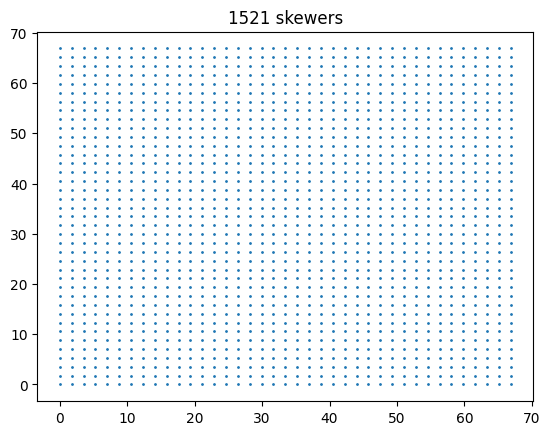

In [5]:
plt.scatter(position_grid[:,:,0], position_grid[:,:,1], s=1)
plt.title(f"{nskew} skewers")

Doing single-skyline masking


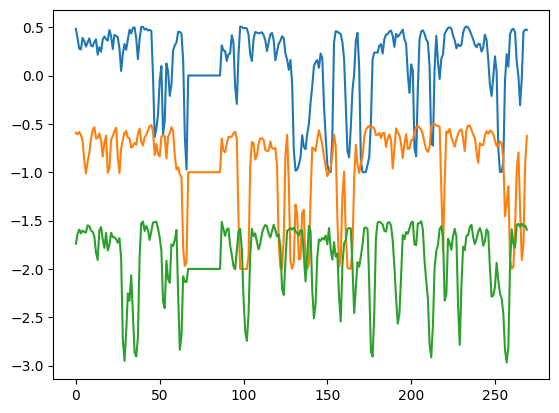

In [6]:
# simple masking: mask a range of N pixels 1/x of the way through the box
print("Doing single-skyline masking") # (with a large width to make the mask effects clear)
skyline_width = 20
boxdiv = 4
sky_maskrange = np.arange(Np//boxdiv, Np//boxdiv+skyline_width)
delta_flux_skyline_grid = np.copy(delta_flux_grid)
delta_flux_skyline_grid[:, :, sky_maskrange] = 0
nmasked_skyline = skyline_width*nskew
skyline_mask = np.ones((nside, nside, Np)) # store the mask
skyline_mask[:, :, sky_maskrange] = 0


# plot the first 3 with an offset
plt.plot(delta_flux_skyline_grid[0,0,:])
plt.plot(delta_flux_skyline_grid[1,0,:]-1)
plt.plot(delta_flux_skyline_grid[2,0,:]-2)

# get the skyline delta k
delta_flux_skyline_k_grid = np.fft.fft(delta_flux_skyline_grid, axis=2)

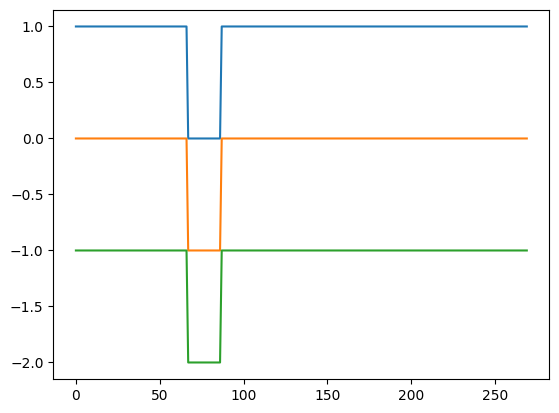

Text(0.5, 0, '$k$ [Mpc$^{-1}$]')

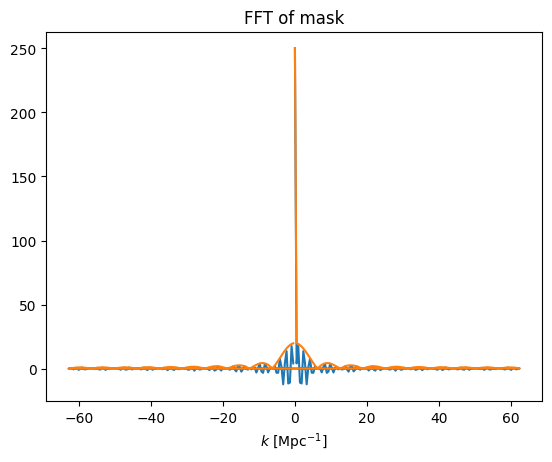

In [24]:
# plot the first 3 masks with an offset
plt.plot(skyline_mask[0,0,:])
plt.plot(skyline_mask[1,0,:]-1)
plt.plot(skyline_mask[2,0,:]-2)
plt.show()
plt.clf()

# get the rfft of the first mask (they are all the same)
kpar = np.fft.fftfreq(Np, pix_spacing)*2*np.pi # frequency in Mpc^-1
skyline_mask_k = np.fft.fft(skyline_mask.reshape(nskew, Np), axis=1)
plt.plot(kpar, skyline_mask_k[0,:].real, label='real part')
plt.plot(kpar, np.abs(skyline_mask_k[0,:]), label='abs value')
plt.title("FFT of mask")
plt.xlabel(r"$k$ [Mpc$^{-1}$]")

In [28]:
nonmask_fft[0]


array([270.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,
         0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+

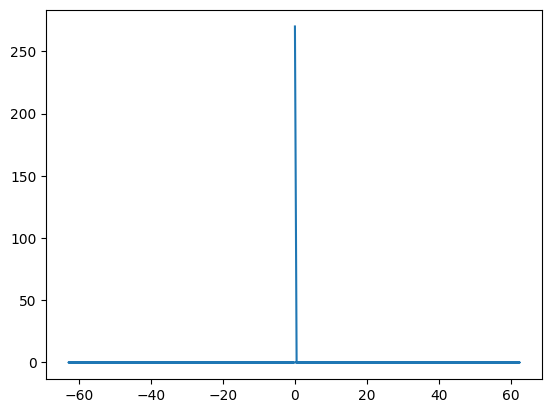

In [41]:
nonmask = np.ones((nskew, Np))
nonmask_fft = np.fft.fft(nonmask, axis=1)
plt.plot(kpar, nonmask_fft[0,:].real, label='real part')

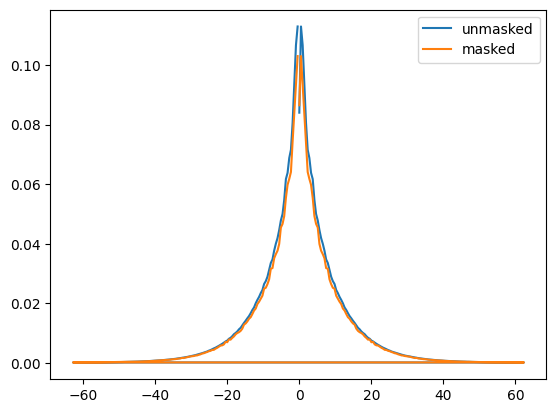

In [8]:
# get the unmasked P1D
p1d_unmasked = np.mean((delta_flux_k.__abs__())**2, axis=0)
# get the masked P1D
p1d_masked = np.mean(np.reshape(delta_flux_skyline_k_grid, (nskew, Nk)).__abs__()**2, axis=0)
# plot them together
plt.plot(kpar, p1d_unmasked*pix_spacing/Np, label="unmasked")
plt.plot(kpar, p1d_masked*pix_spacing/Np, label="masked")
plt.legend()

In [9]:
skyline_mask_k.shape

(1521, 270)

In [44]:

p1d_mask_model_0 = 0
for n in range(Np-1):
    l = 1-n
    print(np.abs(nonmask_fft[0,l])**2, p1d_unmasked[n])
    if l<0:
        p1d_mask_model_0 += np.abs(nonmask_fft[0,Np-np.abs(l)])**2*p1d_unmasked[n]
    else:
        p1d_mask_model_0 += np.abs(nonmask_fft[0,l])**2*p1d_unmasked[n]
p1d_mask_model_0/=Np**2
print(p1d_mask_model_0)

0.0 453.7094042466951
72900.0 610.0392405820825
0.0 576.1908080497544
0.0 504.25834193853814
0.0 434.9978331514328
0.0 386.4355583607217
0.0 371.5529632932962
0.0 344.62169266093514
0.0 333.25387643882203
0.0 295.61557728291734
0.0 269.92271805774004
0.0 258.270842131342
0.0 240.86635647663263
0.0 226.23430838014622
0.0 216.01425258063625
0.0 203.529405671453
0.0 187.5572607368306
0.0 181.11114971378927
0.0 168.28490904751982
0.0 156.13904324533928
0.0 148.22836230400637
0.0 143.02136174120324
0.0 132.06265066372345
0.0 126.47060272700404
0.0 119.62253145294913
0.0 114.18157483074881
0.0 108.0547605042812
0.0 100.4853300358875
0.0 95.8857714800034
0.0 90.0862943252501
0.0 84.84335564648796
0.0 80.81479626065791
0.0 76.39298570056046
0.0 72.4573134121091
0.0 68.04103846684842
0.0 63.53907123703433
0.0 60.78475314935881
0.0 56.97387125683118
0.0 54.18554323207805
0.0 51.927465052814476
0.0 48.28758695134508
0.0 45.357615720905144
0.0 43.61404716800778
0.0 40.37439858974262
0.0 38.7436452

In [45]:
p1d_mask_model = []
for m in range(len(kpar)): # for each Fourier mode
    print(m)
    p1d_mask_model.append(mc.calculate_masked_power_fft(m, skyline_mask_k, p1d_unmasked))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269


(0.0, 40.0)

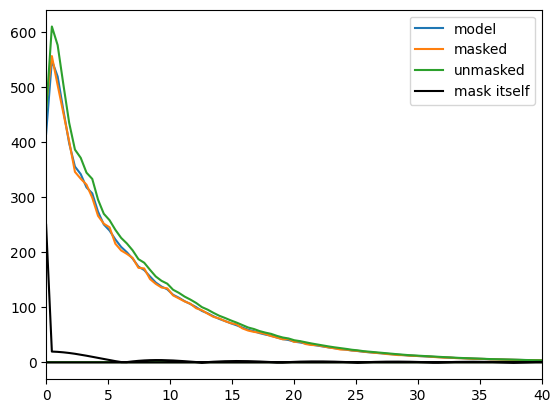

In [46]:
# plot each 
# plt.plot(kpar, np.asarray(p1d_mask_model), label='model')
plt.plot(kpar, np.asarray(p1d_mask_model), label='model')
plt.plot(kpar, p1d_masked, label='masked')
plt.plot(kpar, p1d_unmasked, label='unmasked')
plt.plot(kpar, np.abs(skyline_mask_k[0,:]), label='mask itself', color='k')
plt.legend()
plt.xlim([0,40])
